https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


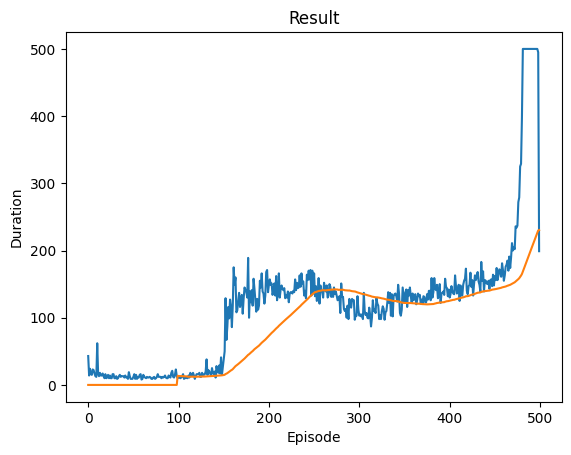

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [6]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500
    
# Initialize a dictionary to store states for each episode
all_states = {}

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Create a list to store states for this episode
    episode_states = []
    
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Append the current state to the list of episode_states
        episode_states.append(state)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            
            # Save the episode_states in the all_states dictionary
            all_states[i_episode] = episode_states
            
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [9]:
len(all_states)

500

In [71]:
import numpy as np

all_states_sequence_list = [sequence for sequence in all_states.items()]
all_states_list = []

for sequence in all_states_sequence_list:
    seq = []
    for val in sequence:
        seq.append(np.array(val))
    all_states_list.append(np.squeeze(np.array(seq[1]),1))

In [108]:
for element in all_states_list:
    print(element)

[[ 3.2045059e-02 -2.4308216e-02 -2.7467752e-02  1.1308366e-02]
 [ 3.1558894e-02 -2.1902570e-01 -2.7241586e-02  2.9519990e-01]
 [ 2.7178381e-02 -4.1374889e-01 -2.1337587e-02  5.7916832e-01]
 [ 1.8903403e-02 -6.0856545e-01 -9.7542210e-03  8.6505377e-01]
 [ 6.7320936e-03 -4.1331208e-01  7.5468547e-03  5.6932002e-01]
 [-1.5341478e-03 -2.1829678e-01  1.8933255e-02  2.7902415e-01]
 [-5.9000831e-03 -2.3449963e-02  2.4513738e-02 -7.6276464e-03]
 [-6.3690827e-03 -2.1891475e-01  2.4361186e-02  2.9268774e-01]
 [-1.0747378e-02 -2.4148447e-02  3.0214939e-02  7.7864737e-03]
 [-1.1230347e-02  1.7052744e-01  3.0370669e-02 -2.7521223e-01]
 [-7.8197978e-03 -2.5014365e-02  2.4866425e-02  2.6892817e-02]
 [-8.3200848e-03  1.6974232e-01  2.5404282e-02 -2.5784191e-01]
 [-4.9252384e-03 -2.5732933e-02  2.0247443e-02  4.2744402e-02]
 [-5.4398971e-03  1.6909291e-01  2.1102332e-02 -2.4348213e-01]
 [-2.0580390e-03  3.6390719e-01  1.6232688e-02 -5.2943486e-01]
 [ 5.2201049e-03  1.6856068e-01  5.6439913e-03 -2.31681

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
import pickle

In [100]:
with open('cartpole_500_episodes_dqn.pkl', 'wb') as f:
    pickle.dump(all_states_list, f, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('cartpole_500_episodes_dqn.pkl', 'rb') as f:
    loaded_pickle = pickle.load(f)

In [6]:
for i in loaded_pickle:
    print(i.shape)

(43, 4)
(14, 4)
(24, 4)
(16, 4)
(15, 4)
(23, 4)
(22, 4)
(17, 4)
(13, 4)
(12, 4)
(62, 4)
(16, 4)
(13, 4)
(18, 4)
(14, 4)
(14, 4)
(17, 4)
(13, 4)
(10, 4)
(16, 4)
(10, 4)
(11, 4)
(15, 4)
(10, 4)
(14, 4)
(10, 4)
(10, 4)
(16, 4)
(16, 4)
(10, 4)
(10, 4)
(13, 4)
(9, 4)
(10, 4)
(13, 4)
(15, 4)
(12, 4)
(13, 4)
(13, 4)
(13, 4)
(11, 4)
(14, 4)
(11, 4)
(12, 4)
(9, 4)
(19, 4)
(13, 4)
(9, 4)
(9, 4)
(9, 4)
(12, 4)
(16, 4)
(9, 4)
(15, 4)
(9, 4)
(12, 4)
(11, 4)
(15, 4)
(16, 4)
(8, 4)
(9, 4)
(15, 4)
(12, 4)
(11, 4)
(10, 4)
(12, 4)
(11, 4)
(11, 4)
(12, 4)
(11, 4)
(9, 4)
(9, 4)
(11, 4)
(12, 4)
(9, 4)
(10, 4)
(12, 4)
(16, 4)
(12, 4)
(12, 4)
(12, 4)
(10, 4)
(12, 4)
(11, 4)
(12, 4)
(14, 4)
(11, 4)
(10, 4)
(10, 4)
(14, 4)
(12, 4)
(11, 4)
(18, 4)
(21, 4)
(12, 4)
(11, 4)
(15, 4)
(23, 4)
(13, 4)
(10, 4)
(11, 4)
(11, 4)
(10, 4)
(11, 4)
(13, 4)
(16, 4)
(9, 4)
(11, 4)
(10, 4)
(11, 4)
(10, 4)
(14, 4)
(11, 4)
(18, 4)
(15, 4)
(14, 4)
(18, 4)
(14, 4)
(9, 4)
(13, 4)
(16, 4)
(16, 4)
(16, 4)
(18, 4)
(12, 4)
(12, 4)
(18, 4

In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [11]:
def tsne_for_cartpole_sequences(sequences, perplexity=5, n_iter=1000, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter)
    return tsne.fit_transform(sequences)

In [13]:
tsne_list = []

for sequence in loaded_pickle:
    tsne_list.append(tsne_for_cartpole_sequences(sequence))

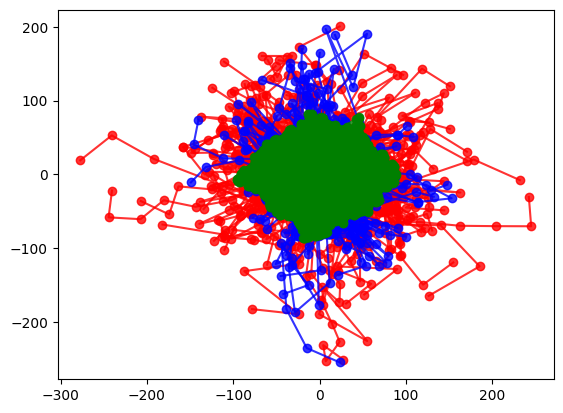

In [34]:
for i, embedding in enumerate(tsne_list):
    if i < 100:
        plt.plot(embedding[:,0], embedding[:,1], '-o', alpha=0.8,c='r')
    if 100 <= i < 480:
        plt.plot(embedding[:,0], embedding[:,1], '-o', alpha=0.8,c='b')
    if i >= 480:
        plt.plot(embedding[:,0], embedding[:,1], '-o', alpha=0.8,c='g')

plt.show()

In [41]:
flattened_data = []
for i, sequence in enumerate(loaded_pickle):
    for j, state in enumerate(sequence):
        flattened_data.append((i, j, *state))

data = np.array(flattened_data)

In [100]:
import pandas as pd
pd.DataFrame(data).to_csv('cartpole_500_episodes_dqn.csv', index=False)

In [44]:
data[:,2:]

array([[ 0.03204506, -0.02430822, -0.02746775,  0.01130837],
       [ 0.03155889, -0.2190257 , -0.02724159,  0.2951999 ],
       [ 0.02717838, -0.41374889, -0.02133759,  0.57916832],
       ...,
       [ 0.97648305,  1.12709188,  0.19162163,  0.18504816],
       [ 0.99902487,  0.92981851,  0.1953226 ,  0.53153473],
       [ 1.01762128,  1.1217345 ,  0.2059533 ,  0.30619505]])

In [55]:
embeddings = tsne_for_cartpole_sequences(data[:,2:], perplexity=30)

In [56]:
embeddings_with_labels = np.hstack((data[:,:2], embeddings))
embeddings_with_labels.shape

(57814, 4)

In [80]:
embeddings_with_labels_and_colors = np.hstack((embeddings_with_labels, data[:,0].reshape(-1,1)))
embeddings_with_labels_and_colors[:,-1] = [1 if i < 100 else 2 if 100 <= i < 480 else 3 for i in embeddings_with_labels_and_colors[:,0]]
embeddings_with_labels_and_colors

array([[  0.        ,   0.        ,  79.81550598,  29.9492588 ,
          1.        ],
       [  0.        ,   1.        ,  59.35156631, 104.19281006,
          1.        ],
       [  0.        ,   2.        ,  10.20936298,  95.7729187 ,
          1.        ],
       ...,
       [499.        , 196.        , 128.49407959, -36.61551285,
          3.        ],
       [499.        , 197.        , 128.55357361, -37.21261597,
          3.        ],
       [499.        , 198.        , 128.56904602, -36.71884918,
          3.        ]])

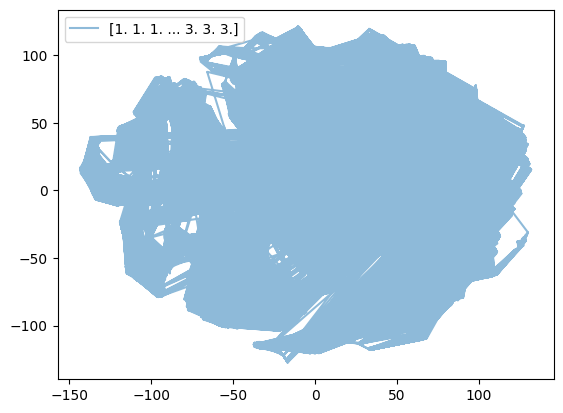

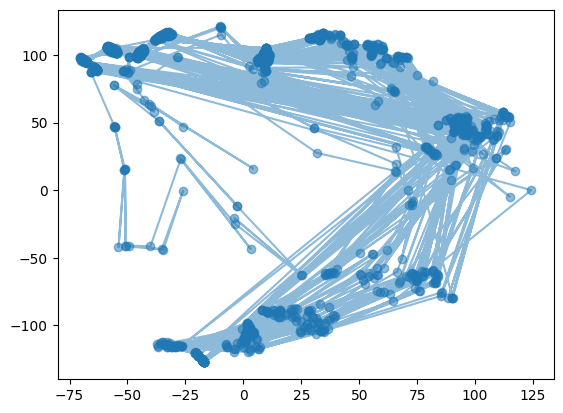

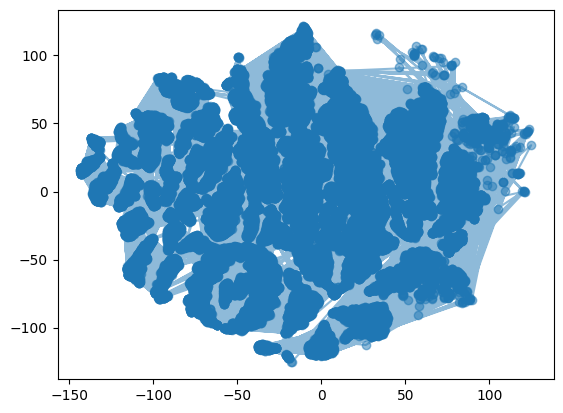

ValueError: array([480., 480., 480., ..., 499., 499., 499.]) is not a valid value for color

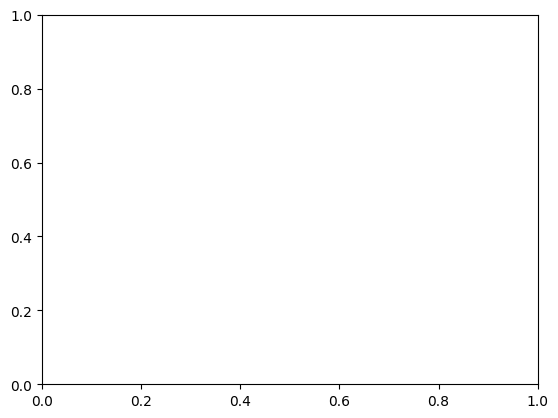

In [85]:
plt.plot(embeddings_with_labels_and_colors[:,2], embeddings_with_labels_and_colors[:,3], label=embeddings_with_labels_and_colors[:,4], alpha=0.5)
plt.legend()
plt.show()

plt.plot(embeddings_with_labels_and_colors[:,2][embeddings_with_labels_and_colors[:,4]==1], embeddings_with_labels_and_colors[:,3][embeddings_with_labels_and_colors[:,4]==1], '-o', alpha=0.5)
plt.show()

plt.plot(embeddings_with_labels_and_colors[:,2][embeddings_with_labels_and_colors[:,4]==2], embeddings_with_labels_and_colors[:,3][embeddings_with_labels_and_colors[:,4]==2], '-o', alpha=0.5)
plt.show()

plt.plot(embeddings_with_labels_and_colors[:,2][embeddings_with_labels_and_colors[:,4]==3], embeddings_with_labels_and_colors[:,3][embeddings_with_labels_and_colors[:,4]==3], '-o', alpha=0.5,
         c=embeddings_with_labels_and_colors[:,0][embeddings_with_labels_and_colors[:,4]==3])
plt.show()

In [96]:
desired_values = [0, 50, 200, 300, 400, 480]
mask = np.isin(embeddings_with_labels_and_colors[:, 0], desired_values)
sliced_embeddings = embeddings_with_labels_and_colors[mask]

sliced_embeddings

array([[   0.        ,    0.        ,   79.81550598,   29.9492588 ,
           1.        ],
       [   0.        ,    1.        ,   59.35156631,  104.19281006,
           1.        ],
       [   0.        ,    2.        ,   10.20936298,   95.7729187 ,
           1.        ],
       ...,
       [ 480.        ,  395.        , -111.80892181,  -60.90329742,
           3.        ],
       [ 480.        ,  396.        ,  -96.32010651,  -78.45078278,
           3.        ],
       [ 480.        ,  397.        , -111.62486267,  -63.10868835,
           3.        ]])

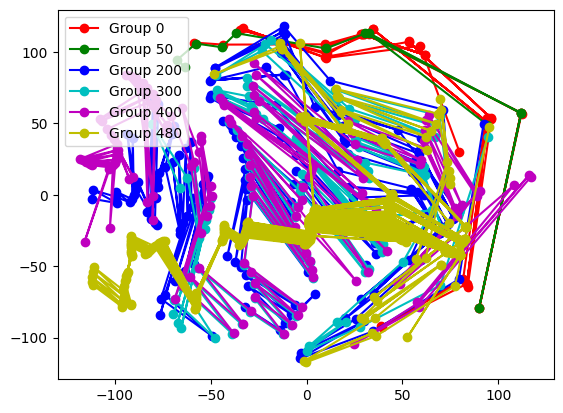

In [97]:
X = sliced_embeddings[:,2]
Y = sliced_embeddings[:,3]
Group = sliced_embeddings[:,0].astype(int)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange', 'pink', 'brown']


for i, group_id in enumerate(np.unique(Group)):
    mask = (Group == group_id)
    plt.plot(X[mask], Y[mask],'-o', label=f'Group {group_id}', color=colors[i])

plt.legend()
plt.show()
